# COGS 118A - Final Project

# Prediction of NBA Injuries from Performance Stats

## Group members

- Bobby Baylon
- Kyra Brandt
- Jayson Gutierrez
- Nathaniel Mackler
- Stephen Rabin

### Code Setup:
Please run the cell below before running any of the code cells in the notebook.

In [1]:
##SET UP (ALL IMPORT STATEMENTS GO HERE)

#general
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline

#KNN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest

#SVM
from sklearn.svm import SVC

#RandomForest
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

#Metrics
from sklearn.metrics import precision_recall_fscore_support, make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import fbeta_score

# Abstract 
 Load management is a significant topic issue in the NBA as it involves the decision-making process of whether a player should play on game day in order to avoid injuries and ensure long-term health and success for both the player and their team. The goal of our project is to create a system for categorizing NBA players' injuries based on performance data. We use a dataset of player's performance statistics and injuries built from web-scraping the NBA API and injury data from Kaggle, which contains XX observations and 80 different features. After doing a combination of hand-design and multicollinearity feature selection, we explore differences in performance between K-Nearest Neighbors, SVM and Random Forest models using recall, f-beta and confusion matrices as metrics. We ultimately find all three models to perform comparably, with SVM doing the best to maximize recall but random forest and KNN providing better balance between recall and precision.

# Background

A hot topic within the current NBA world revolves around the idea of load management. The concept of load management dictates if a player should play on game day and, if they do, how many minutes. One hypothetical example is that an NBA organization might sit their star player out for a game halfway through the season because that player has been used at high rates in recent games. That organization might analyze their star's workload, ask the player how their body is responding, and assess that it's time to give their star a rest to prevent any risk of injuries, minor or major. 
Practicing load management seems like an obvious protocol for an organization in order to preserve both the player and the organization’s future health and success. A study conducted through the 2012-2015 seasons in 17 NBA teams demonstrated that significant factors in player injuries were high game loads and player fatigue <a name="lewis"></a>[<sup>[1]</sup>](#lewisnote). This study reinforces that there’s an interaction between game load and injury risk, thus it's reasonable for fans, organizations, and players to assess minutes and games played to determine if a player should sit to prevent injury. Another study conducted using data from the 2017-2019 seasons found that other risk factors for injury were player age and position <a name="cohan"></a>[<sup>[2]</sup>](#cohannote). This study indicates that seasoned players are more prone to injury and that player build’s are considerable factors in injuries due to the size expectations of certain positions. A relevant article highlighted a trend an increasing injury severity over 11 seasons, attributing the causes to things such as lengthening the season and an increase in athletic intensity<a name="kosik"></a>[<sup>[3]</sup>](#kosiknote). These variables are valuable in selecting specific variables that should be used in a statistical analysis of injury likelihood from player performance.
On the surface, it seems obvious to people outside of the NBA world that you would want to prevent major injuries for the players, that could even be career ending, and that forcing any individual to play regardless of their physical status would be unethical and harmful. However, traditional NBA fans and retired players argue that current players, especially star players, shouldn’t sit due to fatigue or minor injuries as it robs fans of their full experience at an NBA game. When the late great Kobe Bryant was asked why he disapproves of modern NBA players sitting out due to fatigue, he stated this reasoning perfectly, “Because you have a lot of people paying a lot of money to come see these athletes play, and they deserve to see that."

# Problem Statement

The research problem is classifying NBA player injuries as non-injured or injured based on their performance statistics, such as usage rating, minutes played, and games played, and demographics, like age, height, and weight. The purpose of this project is to develop an accurate model that can aid NBA organizations in their decision-making regarding load management and player preservation, as high game loads and player fatigue have been identified as significant factors in player injuries. By identifying common injury risk factors among NBA players based on position and player build, the model can inform preventative measures and training programs, promoting player health and success. As discussed in the background section above, the significance of this research lies in its potential to help NBA organizations improve player health and success, while enhancing the fan experience at NBA games by providing a high level of play while preventing major injuries for the players. In other words, predicting injuries will help players and coaches sustain longer, healthier careers and deliver the performance their fans deserve. This project's impact can contribute to the overall goal of promoting player health and success while also enhancing the fan experience at NBA games.

In approaching feature selection, we use our basketball knowledge to determine which features would be intuitively important as well as analysis of the features to eliminate ones with high collinearity, since many performance statistics are linear combinations of others. 

In approaching model selection, we consider **KNN**, **SVM** and **Random Forest**. KNN is a strong algorithm for multi-class classification, which is importance since we aim to classify injury statuses in a hierachy of non-injured, minor injury or major injury. However, the high dimensionality of our initial dataframe presents a challenge in implementing KNN for this classification task, which further motivates good feature selection. We are not concerned about the high test time of KNN since, in industry, this algorithm would only have to be used around 10^4 or 10^5 times per year. 

SVM is a good fit for our project because it is an easily interpretable model. Interpretability is an important factor at play because if our model predicts that a player should sit out or take time off, players, coaches and fans are going to want to know why. Our model being interpretable is also important because, if accurate and interpretable, the model could provide motivation for adjustment of training regimes, leading to greater longevity in player careers. SVM kernels also introduce nonlinear transformations which will be importance since, as shown later, our data is not easily linearly separable.

Finally, we explore random forest since random forest has built in feature selection. Thus, random forest provides both another model to consider for our project but also another route for feature selection for us to compare with what we come up with in our feature selection. 


# Data

We combine data from the Kaggle Injury Data 2010-2020 and the nba_api (both of which are described below) to create a final cleaned dataframe pairing individual player performance statistics with whether or not players were injured that particular season. If the player was injured, we also have a column for whether their injury was minor or severe. We will use this merged dataframe as the basis of our model.

The dataframe was constructed from the datasets below, both of which are in the Repo (as is our final dataframe) if you wish to view them:

**Injury Data 2010-2020 (Kaggle):**
- Link: https://www.kaggle.com/datasets/ghopkins/nba-injuries-2010-2018?resource=download 
- Repo Link: https://github.com/COGS118A/Group014-Wi23/blob/main/injuries_2010-2020.csv
- Dataset size: 27,106 X 5 = 27,106 observations and 5 variables
- A single observation consists of the name of the injured player, the team they played for while injured, notes detailing the injury, injury leave, and/or return from injury, and the date for which the player either left on injury leave or returned to play. 
- Some critical variables are the Required, Relinquished, and Notes variables. Required and Relinquished (based on whether or not a name is present) indicate whether a player is going on injury leave or returning to the field of play. Both of these variables are represented as string values and are categorical. The Notes variable contains more specific information on the injury (i.e. did not play or day-to-day [which is questionable to play]) and/or indicates the beginning or end of injury leave for a player. The Notes variable is represented as a string. 
- **DATA CLEANING:** This dataset was cleaned using string parsing to determine if a particular injury was minor or severe. A minor injury was defined to be an injury that keeps a player out of the game for one game or less, while a severe injury was one that kept the player out for more than one game. We determined which type of injury was which using string parsing - for example, a string containing “dtd” (day-to-day) indicated a minor injury, while words like “ACL” indicated severe injuries. Due to the fact that one injury could be featured in the kaggle dataset anywhere from 1-10+ times, we whittled the dataset down to recording whether a player was uninjured, minorly injured, severely injured, or both in each season. *(To see this process more in depth, please see our DataCleaningEDA118a notebook, linked here: https://github.com/COGS118A/Group014-Wi23/blob/main/DataCleaningEDA118a.ipynb)*
- **FINAL VERSION:** At the end of our cleaning, we had 3796 observations of 4 variables (see below): season_year, player name, and a boolean for minor and severe injury. This was left-joined with our performance stats from the NBI API dataset, and NaNs were replaced with falses, since not being in the injuries dataset means a player wasn’t injured. We did have to discard approximately 4% of the injury data due to names being stored in a different format; we expect that this will slightly bias our model to underpredict injuries, but the dataset was too large to realistically go through and fix this by hand given the time frame. *(As above, this process can be seen in depth in the DataCleaningEDA118a.ipynb notebook in our repo linked above.) 

![Clean_head](images/Clean_injury_head.png)

**nba_api for web scraping (GitHub):**
- Link: https://github.com/swar/nba_api
- Repo Link: https://github.com/COGS118A/Group014-Wi23/blob/main/AdvStats09-23.csv
- Dataset size: 6593 observations x 80 variables.
- An observation consists of around 80 performance statistics for a given player (i.e. time played, points scored, number of rebounds, average free throws made, etc.) along with their name, player ID, some demographics (ex. age) and the season.
- Critical variables are the player's name and season because these are important for matching our dataframes as well as the performance statistics and demographics since these are the features we will feed into our models. Of the many player statistics we have data for, we expect to focus on variables that highlight general player performance, like average time played, average points scored in a game, and average shots made which would all be represented as integer values. A core element of our project moving forward will be to do feature selection from these performance and demographic statistics. 
- **RETRIEVAL PROCESS:** We retrieved advanced statistics data for NBA players from the 2009-2010 season to the present season. We first queried the NBA website for a table that included the identification information of all players on record, which was then filtered to include only those who have played since the 2009-2010 season. This process of retrieval took advantage of the NBA_API's 'player.py' module which provides access to a static database of all players that the NBA has recorded statistics for. Then, for each season, advanced stats data is retrieved and filtered to only include players who played in that season using the NBA_API's leaguedashplayerstats endpoint that accesses the advanced statistics for NBA players under some specified criteria. The resulting dataframes of each season's advanced stats for each player are concatenated into a single dataframe containing advanced stats data for all NBA players who have played since the 2009-2010 season. The resulting dataframe can be used for further analysis of NBA player performance.

![NBA_head](images/NBA_stat_head.png)

**Final Dataframe**
- Link: https://github.com/COGS118A/Group014-Wi23/blob/main/nba_api_merged_injuries
- Dataset size: 6593 observations x 81 variables
- A single observation consists of around 80 performance statistics connected for a single player for a single season and whether or not they sustained a severe injury or a minor injury. 
- A large portion of our project is the feature selection we did to determine what critical variables are. We used the variables for whether or not they were injured to as the ground truth labels for our model. 
- The data cleaning process used to create this dataframe is described above and more in depth in the DataCleaningEDA118a notebook (https://github.com/COGS118A/Group014-Wi23/blob/main/DataCleaningEDA118a.ipynb).

![Merged_head](images/merged_head.png)

# Proposed Solution

**Feature Selection:** Of our 81 features in our final dataset, we need to perform feature selection to determine which of them are the most useful and which can be excluded. We make use of our intuition as a first step, eliminating obvious things like player_id, player_name, nickname and selecting one from redundant sets like team_id and team_abbreviation. Then we analyze the relationships between features since some performance statistics are linear combinations of others. Having eliminated those features, we can procede to model construction and selection. Additionally, the random forest model provides us with a sanity check of feature selection because this model has built in feature selection. 

**Model Selection:** As mentioned previously, K-nearest neighbors is an obvious solution for this problem. Realistically, one would need to predict the injury class of NBA players no more frequently than tens of thousands of times per year. Therefore, the high complexity of testing with KNN is not a huge issue. The curse of dimensionality is also not a significant problem, as we have thousands of data points but only tens of features. However, a large vulnerability would be the risk of useless features affecting our KNN classifier. This is why it is so important we do good feature selection and scale our data appropriately. SVM also presents another proposed solution. We experiment with an RBF kernel and look into others appropraite for a dataset with more observations than features as a potential hyperparameter. We also saw potential in exploring grid search CV as a means of doing further feature selection by using different values of C (the "hardness of the margin") and different sets of features (from the ones selected on intution and research as described above). Finally, random forests is a useful solution because of its interpretability and automated feature selection. This automated feature selection removes biases that our intuition may introduce and may reveal patterns we had not anticipated. 

Previous studies' models, such as that conducted by Lewis or Cohan & Schuster, have used only player age and minutes played, since intuitively, these two factors are by far the most important in predicting whether a player will be injured. For this reason, our benchmark model is the  regression using only age and minutes played for input, so if a complex model fails to do significantly better than this model, we can safely dismiss it as not useful. Additionally, in our feature selection, we will use those two features (age, minutes played) as our baseline for determining our additional performanace features are useful.

# Evaluation Metrics

While there are certainly consequences for a false positive in this case (like potentially hurting a player's mindset or causing them to reduce their performance), the consequences of a false negative (an injury occuring that could have been prevented or whose probability could be reduced through better form/training moderation) are far worse. The obvious error metric for this case would be recall (TP/(TP+FN)), but this metric would give zero weight to false positives. The harm of false positives is not zero, just lower than that of false negatives. Therefore, we find the best metric would be an Fbeta metric. The value of beta is subjective. We  play around with a few values to determine the beta that “feels” right but use one to weight recall higher.

We also utilize confusion matrices to visualize the difference metrics.

# Results

### 1: Feature Selection

The full code for this section can be found here: https://github.com/COGS118A/Group014-Wi23/blob/main/COGS_118A_Final_Basic_Feature_Selection_Copy1.ipynb 

First feature drop in manual feature selection:

In [2]:
# import the merged data set
url = "https://raw.githubusercontent.com/COGS118A/Group014-Wi23/main/nba_api_merged_injuries"
data = pd.read_csv(url)

nba_variables = data.iloc[:,5:-3]
mcr = nba_variables.corr()

cmap = sns.diverging_palette(220, 20, n=200, as_cmap=True)
#cmap = sns.color_palette("seismic", as_cmap=True, n_colors=256)
#cmap.set_bad(color='white')
#cmap.set_over(cmap(1.0))
#cmap.set_under(cmap(0.0))
#center = 0.0

plt.figure(figsize=(200,200))
sns.heatmap(mcr, annot=True, cmap=cmap, center=0, vmin=-1, vmax=1)
plt.savefig('heatmap.png')


The final dataset has 81 features and we needed to do a feature selection to identify the most statistically useful ones. Based on intuition we eliminated obvious variables such as player_id, player_name, nickname, team_id, and team_abbreviation. We also excluded any redundant features that would not contribute to predicting injury. The correlation between the features was modeled via heat map visualizations each time we dropped features deemed irrelevant. For the KNN and SVM models, we utilized only 20 of the total possible variables for model selection, while for the random forest model, we used the entire set of features. 

Several variables were removed from the final dataset due to their inability to meaningfully contribute to the prediction. Variables such as “rank” and “NET” provide no additional information and are simply a combination of the existing raw data, adding only unnecessary computational complexity. As field goals attempted (FGA) is a better measure for player injury risk, we excluded field goals made (FGM) since they strongly correlate with attempts, and shooting frequently can be physically taxing. Upon further consideration, we found there to be no advantage in keeping FGA when the same information could be gathered via the variables: field goal attempts per game (FGA_PG) and minutes played (MIN). We dropped wins and losses as these have as much to do with the team than it does the player, and also has high multicollinearity with games played (GP).


In [3]:
nba_variables = nba_variables.drop(nba_variables.filter(like='RANK').columns, axis=1)

nba_variables = nba_variables.drop(nba_variables.filter(like='NET').columns, axis=1)
nba_variables = nba_variables.drop(nba_variables.filter(like='FGM').columns, axis=1)
nba_variables = nba_variables.drop('FGA', axis=1)

nba_variables = nba_variables.drop('W', axis=1)
nba_variables = nba_variables.drop('L', axis=1)

nba_variables.head()

,AGE,GP,W_PCT,MIN,E_OFF_RATING,OFF_RATING,sp_work_OFF_RATING,E_DEF_RATING,DEF_RATING,sp_work_DEF_RATING,...,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,sp_work_PACE,PIE,POSS,FGA_PG,FG_PCT
0,24.0,50,0.440,15.9,104.3,104.4,104.4,102.7,102.2,102.2,...,0.223,0.227,95.35,95.56,79.63,95.56,0.075,1579,6.4,0.356
1,26.0,59,0.441,21.8,105.9,106.8,106.8,112.5,113.4,113.4,...,0.251,0.257,96.79,96.01,80.01,96.01,0.078,2571,9.9,0.375
2,26.0,41,0.512,12.9,107.4,107.4,107.4,105.3,103.5,103.5,...,0.130,0.132,89.79,90.56,75.47,90.56,0.065,997,2.4,0.566
3,26.0,51,0.392,14.2,100.1,99.0,99.0,108.2,107.8,107.8,...,0.156,0.160,95.96,96.68,80.56,96.68,0.070,1460,3.6,0.435
4,31.0,73,0.616,22.8,110.3,111.6,111.6,106.7,106.9,106.9,...,0.219,0.221,98.80,98.16,81.80,98.16,0.078,3389,9.2,0.416


Since the offensive rating (OFF_RATING) has a high multicollinearity rating (MCR) with the offensive efficiency rating, we excluded the OFF_RATING. Likewise, we dropped scored points (sp_WORK_OFF_RATING), (EFG_PCT), and (TS_PCT) as these are composite statistics, and hence contain redundant information. Similarly, we removed team turnover percentage (TM_TOV_PCT) due to its being a team metric with high MCR. Additionally, we retained PACE_PER_40 but dropped the variables that contain metrics that track the number of possessions a team makes per game: PACE, e_PACE, sp_WORK_PACE. 


In [4]:
nba_variables = nba_variables.drop('OFF_RATING', axis=1)
nba_variables = nba_variables.drop('sp_work_OFF_RATING', axis=1)
nba_variables = nba_variables.drop('DEF_RATING', axis=1)
nba_variables = nba_variables.drop('sp_work_DEF_RATING', axis=1)
nba_variables = nba_variables.drop('EFG_PCT', axis=1)
nba_variables = nba_variables.drop('TS_PCT', axis=1)

Final feature drop in manual feature selection:


<AxesSubplot:>

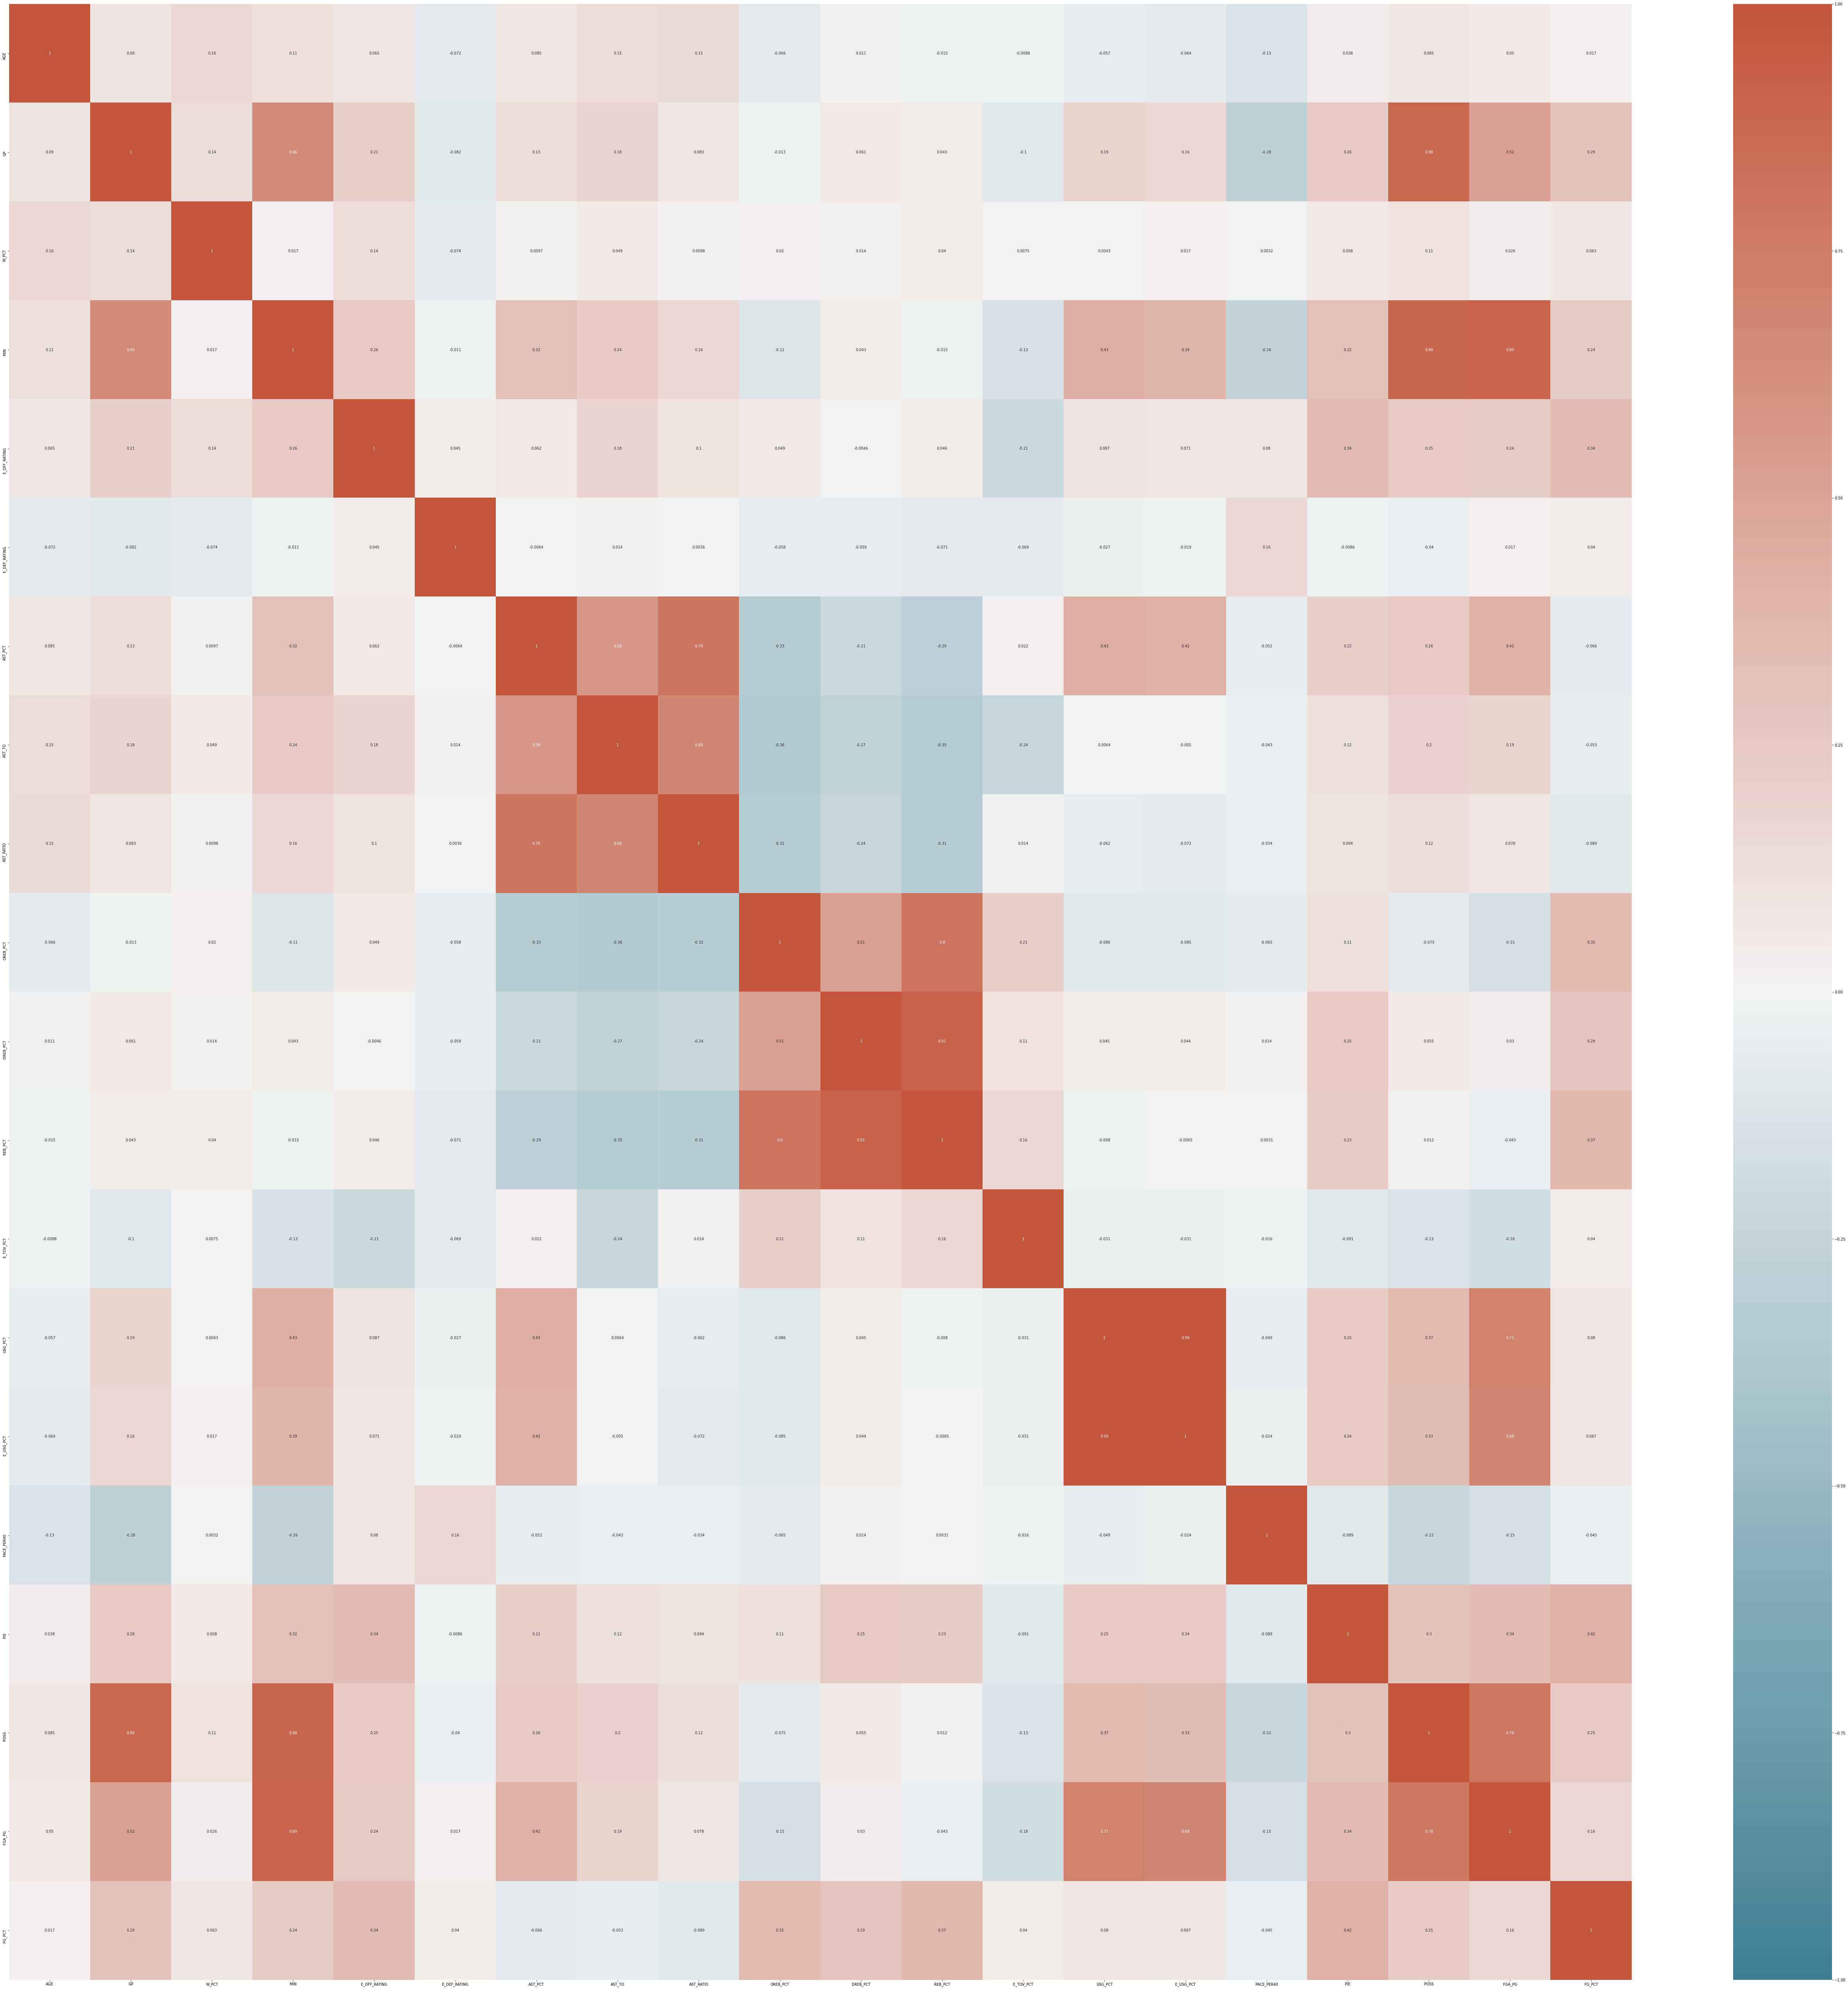

In [5]:
nba_variables = nba_variables.drop('TM_TOV_PCT', axis=1)
nba_variables = nba_variables.drop(columns = [ 'PACE', 'sp_work_PACE', 'E_PACE'])

mcr = nba_variables.corr()
plt.figure(figsize=(100,100))
sns.heatmap(mcr, annot=True, cmap=cmap, center=0, vmin=-1, vmax=1)

In [6]:
vars_to_keep = nba_variables.columns
vars_to_keep

Index(['AGE', 'GP', 'W_PCT', 'MIN', 'E_OFF_RATING', 'E_DEF_RATING', 'AST_PCT',
       'AST_TO', 'AST_RATIO', 'OREB_PCT', 'DREB_PCT', 'REB_PCT', 'E_TOV_PCT',
       'USG_PCT', 'E_USG_PCT', 'PACE_PER40', 'PIE', 'POSS', 'FGA_PG',
       'FG_PCT'],
      dtype='object')

### 2: Preliminary KNN Model

The full code for this section can be found here: https://github.com/COGS118A/Group014-Wi23/blob/main/PreliminaryResults118a.ipynb

We built two separate KNN models for our project. The first comprised our preliminary results section in the project checkpoints and due to time constraints was a binary classifier. This first model was implemented in a pipeline utilizing the default scaling settings. We fit this pipeline on the raining dataset and then used it to predict results for the testing dataset. Since everything was set to default and this was the most basic model we could build (especially given the time constraints), this preliminary KNN model serves as our "default" algorithm for characterizing performance.

The precision is 0.6995412844036697, the recall is 0.7840616966580977, and the fbeta with beta=2 is 0.7655622489959839


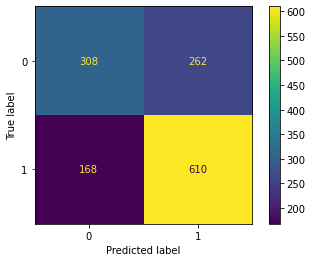

In [7]:
#PRELIMINARY MODEL:

#read in data
url = "https://raw.githubusercontent.com/COGS118A/Group014-Wi23/main/nba_api_merged_injuries"
data = pd.read_csv(url)

data.loc[:,["SEVERE_INJURY", "MINOR_INJURY"]] = data[["MINOR_INJURY", "SEVERE_INJURY"]].fillna(False) #replaces NAs with falses, because 
#NAs mean there was nothing in the injury set when we did the join

features = data.columns[5:-3]
X = data[features].copy()
injuries = data.columns[-2:]
y = data[injuries].copy()
X = X.values
# make this a two-class classifier with injured or not, treating minor and major as the same. This is just for preliminary results,
# we will explore multi-class solutions later
y['INJURY'] = (y['SEVERE_INJURY'] | y['MINOR_INJURY'])
y = y[['INJURY']]
y = np.ravel(y.values)

#gotta do GroupShuffleSplit so we don't end up with people testing against themselves
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X=X, y=y, groups=data['PLAYER_NAME']))
X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]

knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),   # Step 1: Preprocessing with StandardScaler
    ('knn', KNeighborsClassifier()) # Step 2: KNN classification
])

knn_pipeline.fit(X_train, y_train)
y_pred = knn_pipeline.predict(X_test)

def fbeta_score_man(y_true, y_pred, beta):
    precision, recall, fbeta, _ = precision_recall_fscore_support(y_true, y_pred, beta=beta, average="binary")
    return precision, recall, fbeta

precision, recall, fbeta = fbeta_score_man(y_test, y_pred, 2)
print(f"The precision is {precision}, the recall is {recall}, and the fbeta with beta=2 is {fbeta}")

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

We demonstrated the suitability of this intial model through precision, recall and F-beta metrics of the KNN algorithm for the binary classification. This preliminary exploration yielded a precision value of 0.69, suggesting this model identifies a greater number of true positives with some false positives. We got a recall value of 0.78 which implies that our initial model still results in 0.22 misclassifications (false negatives). While this score is larger than the precision found, we believe it is possible to perform even better. Lastly, our F-beta value was 0.76 with beta = 2 where recall is weighted twice as much as precision. F-beta scores are a measure of the model’s accuracy based on both the precision and recall. Getting a value of 0.76 means we are classifying more samples than not. Though these scores are not terrible, we have confidence in our abilities to improve our current model, or identify another one capable of yielding greater confidence in our predictions. 


### 3: KNN Model with Selected Features

The full code for this section can be found here: https://github.com/COGS118A/Group014-Wi23/blob/main/KNN_Model_118A.ipynb

Having thus established a baseline and completed our feature selection, we set to work constructing a second KNN model, this time using the 20 features we had selected. We used the same pipeline as we had for our baseline model and again used GroupShuffleSplit to avoid the same individual presenting in the training and testing set. We then performed grid search cross validation to determine the best value of k, checking every odd k from 1-72. We then extracted the k with the best f-beta score.

As above, we then calculated the precision, recall and f-beta score for this model, which are printed below. 


The best value of k is 71.
The precision is 0.6840958605664488, the recall is 0.8071979434447301, and the fbeta with beta=2 is 0.7791563275434242


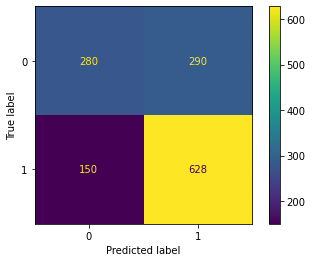

In [8]:
cols_list = ['AGE', 'GP', 'W_PCT', 'MIN', 'E_OFF_RATING', 'E_DEF_RATING', 'AST_PCT',
       'AST_TO', 'AST_RATIO', 'OREB_PCT', 'DREB_PCT', 'REB_PCT', 'E_TOV_PCT',
       'USG_PCT', 'E_USG_PCT', 'PACE_PER40', 'PIE', 'POSS', 'FGA_PG',
       'FG_PCT'] # importing the columns that we went through for manual feature selection

X = data.loc[:,cols_list]
y = data.iloc[:,-2:]
y['INJURY'] = (y['SEVERE_INJURY'] | y['MINOR_INJURY'])
y = y[['INJURY']]
y = np.ravel(y.values)
X = X.values

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42) # as per TA feedback, we implement Group Shuffle Split to ensure each
# player is either all in the train set or all in the test set, even if we have multiple years of data for them. 
train_idx, test_idx = next(gss.split(X=X, y=y, groups=data['PLAYER_NAME']))
X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]
    
def fbeta_score_gridsearchcv(y_true, y_pred, beta):
    precision, recall, fbeta, _ = precision_recall_fscore_support(y_true, y_pred, beta=beta, average="binary") #slight modification of error function for the gridsearch
    return fbeta

param_grid = {'knn__n_neighbors': range(1, 73, 2)}

grid_search = GridSearchCV(estimator=knn_pipeline, param_grid=param_grid, scoring=make_scorer(lambda y_true, y_pred: fbeta_score_gridsearchcv(y_true, y_pred, beta = 2)), cv=5)

grid_search.fit(X_train, y_train)

best_k = grid_search.best_params_['knn__n_neighbors']
precision, recall, fbeta = fbeta_score_man(y_test, grid_search.predict(X_test), 2)
print(f"The best value of k is {best_k}.")
print(f"The precision is {precision}, the recall is {recall}, and the fbeta with beta=2 is {fbeta}")

cm = confusion_matrix(y_test, grid_search.predict(X_test))
disp1 = ConfusionMatrixDisplay(cm)
disp1.plot()

Interestingly, our model using the manually selected features resulted in only a slightly higher F-beta score than the original/preliminary model, which would seem to suggest that feature selection was not as big a deal as anticipated or that we chose the wrong features. Because with 80 features we have 2^80 possibly combinations of features, a grid search for feature selection would be too time and computationally intensive to feasibly complete. While we could try a random search, we decided it was a better choice to reevaluate once we had the feature selection from the Random Forest model to compare with. 

### 4: SVM Model

The full code for this section can be found here: https://github.com/COGS118A/Group014-Wi23/blob/main/SVMModel.ipynb

We then moved onto creating our SVM model. As mentioned above, SVM is valuable because it is interpretable and the different kernels, such as rbf and polynomial, allow us to fit to data that is not linearly separably. We discovered this by using PCA to project the data to a 2D space. 

![pca_image](images/pcaupdate.png)


*Please note: This analysis reflects the 20 hand-selected features used in our final models, although the comparable accuracy between the two KNN models suggests that the 20 feature picture would not be very different.The code used to construct this image, along with those for all 80 features, can be found in Kyra_EDA_notebook.ipynb (link: https://github.com/COGS118A/Group014-Wi23/blob/main/Kyra_EDA_notebook.ipynb )* 

As can be seen, the data is very mixed together and not easily separable. This necessitates the use of a nonlinear kernel. For our SVM model, we explored both polynomial and rbf kernels. For the polynomial, we investigated degrees 2, 3 and 7. We also explored C values of 1 and 10. 


In [9]:
dataset = pd.read_csv('nba_api_merged_injuries')
features = dataset[['AGE', 'GP', 'W_PCT', 'MIN', 'E_OFF_RATING', 'E_DEF_RATING', 'AST_PCT',
       'AST_TO', 'AST_RATIO', 'OREB_PCT', 'DREB_PCT', 'REB_PCT', 'E_TOV_PCT',
       'USG_PCT', 'E_USG_PCT', 'PACE_PER40', 'PIE', 'POSS', 'FGA_PG',
       'FG_PCT']]
features = features.values

labels = pd.read_csv('https://raw.githubusercontent.com/COGS118A/Group014-Wi23/main/nba_api_merged_injuries').iloc[:,-2:]
labels = labels.fillna(False)
labels['INJ'] = (labels['SEVERE_INJURY'] | labels['MINOR_INJURY'])
labels = labels[['INJ']]
labels = np.ravel(labels.values)

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42) # as per TA feedback, we implement Group Shuffle Split to ensure each
# player is either all in the train set or all in the test set, even if we have multiple years of data for them. 
train_idx, test_idx = next(gss.split(X=features, y=labels, groups=dataset['PLAYER_NAME']))
X_train, y_train = features[train_idx], labels[train_idx]
X_test, y_test = features[test_idx], labels[test_idx]

def fbeta_score_j(y_true, y_pred):
    precision, recall, fbeta, _ = precision_recall_fscore_support(y_true, y_pred, beta=2, average="binary") #error function for our F beta which weights recall more than precision
    return precision, recall, fbeta
    
def fbeta_score_gridsearchcv(estimator, X, y):
    y_pred = estimator.predict(X)
    precision, recall, fbeta, _ = precision_recall_fscore_support(y, y_pred, beta=2, average="binary") #slight modification of error function for the gridsearch

    return {'precision': precision, 'recall': recall, 'fbeta' : fbeta}

SVC_pipeline = Pipeline([
    ('scaler', StandardScaler()),   # Step 1: Preprocessing with StandardScaler
    ('svm', SVC()) # Step 2: SVC classification
])

param_grid = {'svm__kernel': ('poly', 'rbf'),
              'svm__C' : (1,10),
              'svm__degree' : (2,3,7)
             }

grid_search = GridSearchCV(estimator=SVC_pipeline, param_grid=param_grid, scoring=fbeta_score_gridsearchcv, cv=5, refit='recall')


In [10]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm', SVC())]),
             param_grid={'svm__C': (1, 10), 'svm__degree': (2, 3, 7),
                         'svm__kernel': ('poly', 'rbf')},
             refit='recall',
             scoring=<function fbeta_score_gridsearchcv at 0x0000029045DA14C0>)

We fit the SVM model on the data for the 20 hand-selected features, and used a grid search to find the best model with respect to the F-beta score using beta = 2. As can be seen below, our grid search revealed a model with low regulation (C = 1) and a second degree polynomial to be the best choice. The highest F-beta score achieved on all the models generated during the grid search was 94%, and the average f-beta score was .84%, making this the best performing model out of all of the models we generated for our project. We should also note the very high recall on this model. Although we are using f-beta as our primary metric, we are doing this because of our emphasis on recall for our project so this is also a good sign for us. The caveat for this is the low precision model, which is reflected most dramatically in the confusion matrix, especially when compared with confusion matrices for the other models. 

The best params is {'svm__C': 1, 'svm__degree': 2, 'svm__kernel': 'poly'}.
The best estimator is Pipeline(steps=[('scaler', StandardScaler()),
                ('svm', SVC(C=1, degree=2, kernel='poly'))]).
The best score is 0.9349771689497718.
The precision is 0.5944849959448499, the recall is 0.9421593830334191, and the f-score 0.8434982738780208


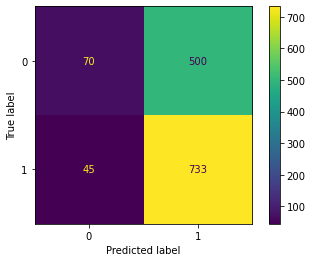

In [11]:
best_params = grid_search.best_params_
print(f"The best params is {best_params}.")
best_est = grid_search.best_estimator_
print(f"The best estimator is {best_est}.")
best_score = grid_search.best_score_
print(f"The best score is {best_score}.")

precision, recall, fbeta = fbeta_score_j(y_test, grid_search.predict(X_test))
print(f"The precision is {precision}, the recall is {recall}, and the f-score {fbeta}")

cm = confusion_matrix(y_test, grid_search.predict(X_test))
disp2 = ConfusionMatrixDisplay(cm)
disp2.plot()

### 5: Random Forest 

The full code for this section can be found here: https://github.com/COGS118A/Group014-Wi23/blob/main/RandomForestModel.ipynb

Having built our KNN and SVM models, we move to our final model: Random Forest. We used the same 20 hand selected features, split into training and test data using GroupShuffleSplit and trained the model.

In [12]:
# import the merged data set
url = "https://raw.githubusercontent.com/COGS118A/Group014-Wi23/main/nba_api_merged_injuries"
data1 = pd.read_csv(url)

# Create a new column "INJURY" based on the "MINOR" and "SEVERE" columns
data1['INJURY'] = (data1['MINOR_INJURY'] == True) | (data1['SEVERE_INJURY'] == True)


# Select the features and target columns
X = data1.loc[:,['AGE', 'GP', 'W_PCT', 'MIN', 'E_OFF_RATING', 'E_DEF_RATING', 'AST_PCT',
       'AST_TO', 'AST_RATIO', 'OREB_PCT', 'DREB_PCT', 'REB_PCT', 'E_TOV_PCT',
       'USG_PCT', 'E_USG_PCT', 'PACE_PER40', 'PIE', 'POSS', 'FGA_PG',
       'FG_PCT']]
y = data1['INJURY']

# Perform Train Test Split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform Shuffle Split 
# shuffle_split = ShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 142)
# for train_index, test_index in shuffle_split.split(X):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42) # as per TA feedback, we implement Group Shuffle Split to ensure each
# player is either all in the train set or all in the test set, even if we have multiple years of data for them. 
train_idx, test_idx = next(gss.split(X=X, y=y, groups=data1['PLAYER_NAME']))
X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
    

# Create a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=142)

# Train the model
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=142)

Having built and trained the model, we calculated its performance on our given metrics. It had a precision around 75%, recall around 75% and an f1-score around 75%, yielding an accuracy score of 71%. It's F-beta score (calculated with beta = 2) is 75%, making it comparable to the KNN models' performance.

Classification Report:
              precision    recall  f1-score   support

       False       0.66      0.65      0.66       570
        True       0.75      0.75      0.75       778

    accuracy                           0.71      1348
   macro avg       0.71      0.70      0.70      1348
weighted avg       0.71      0.71      0.71      1348

Accuracy Score:
0.712166172106825
F-beta Score binary:
0.7516005121638925
Confusion Matrix:


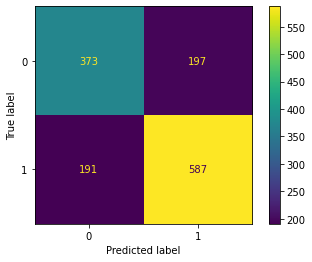

In [13]:
# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the classifier
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))

# Compute F-beta score
beta = 1
#fbeta_w = fbeta_score(y_test, y_pred, beta=beta, average='weighted')
fbeta_b = fbeta_score(y_test, y_pred, beta=beta, average='binary')

# print("F-beta Score weighted:")
# print(fbeta_w)

print("F-beta Score binary:")
print(fbeta_b)

print("Confusion Matrix:")
#print(confusion_matrix(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp3 = ConfusionMatrixDisplay(cm)
disp3.plot()

One of the most important parts of the Random Forest for our purposes was the feature selection. When fed the 20 features we preselected for our three models, it gave the most importance to E_DEF_RATING followed by PACE_PER40, GP and E_OFF_RATING. This makes intuitive sense since defending can be very intense and physical, and players with good defensive ratings will be playing a lot of intense defense. PACE_PER40 reflects the amount of possessions in games, so a higher pace probably indicates more intense, fast play with less rest time for players. GP, or games played, makes sense to be a factor. If you play more, you are more likely to get injured. Therefore, this ranking of feature importance tracks with our intuition.

In [14]:
feat_imp = clf.feature_importances_

feature_importance = pd.DataFrame(cols_list)
feature_importance['CLF_importance'] = feat_imp
feature_importance.columns = ['Feature', 'Importance']
feature_importance = feature_importance.sort_values('Importance', ascending = False)
feature_importance

,Feature,Importance
5,E_DEF_RATING,0.123480
15,PACE_PER40,0.089011
1,GP,0.088384
4,E_OFF_RATING,0.078634
17,POSS,0.056129
2,W_PCT,0.047801
3,MIN,0.044051
12,E_TOV_PCT,0.041308
19,FG_PCT,0.039649
18,FGA_PG,0.039161


Interestingly, when we constructed a random forest model not using the pre-selected 20 features (as can be seen in the RandomForestModel notebook), the model had a higher accuracy and a different set of more important features. 
![fullyfree](images/fullyfreerf.png)

As shown below, a model with no human feature selection (except for removing names, redundant columns and labels) had higher accuracy and better performance on our metrics. The F-beta score on this model was 87% which appears to be a marked increase from the 75% achieved on the model with preselected features. It is important to be wary of these results, however, since they may reflect an interaction among features rather than a substantial improvement. The first 20 highest ranked features  for this model are shown below:
![features2electricboogaloo](images/All_feat_imp.png)\
The most important feature is not E_DEF_RATING but the season. Interestingly, this feature is excluded in our preselected features. It may make sense that the year has an effect on injury prediction, since factors like training regime trends, player mentality and game schedule may change from year to year, but it also good to be wary of taking this too much to heart since the year also introduces time confounds the model may be overfitting to that would keep the model from effectively generalizing when given more data. 

# Discussion

### Interpreting the result

OK, you've given us quite a bit of tech informaiton above, now its time to tell us what to pay attention to in all that.  Think clearly about your results, decide on one main point and 2-4 secondary points you want us to understand. Highlight HOW your results support those points.  You probably want 2-5 sentences per point.

**Feature Selection:**
With respect to the process for feature selection, we identified the most statistically useful variables to use in our final dataset. This procedure was critical for improving the performance and reliability of our chosen models, as well as reducing the computational complexity associated with a large dataset. By removing irrelevant and redundant features, we hoped to create a more streamlined dataset, thus resulting in a better prediction for player injuries. Variables such as RANK and NET were removed because they provide no useful information. Furthermore, we removed highly correlated variables to avoid multicollinearity issues. We knew that keeping field goal attempts per game (FGA PG) and minutes played (MIN) as these provide relevant information for further analysis. Another aspect of our feature selection process was to eliminate composite statistics and team related metrics as these have no direct relationship with an individual player’s performance or injury risk. Scored points, effective field goal percentage, and true shooting percentages were not included as they contained redundant information. Furthermore, variables tracking team turnover percentage and possessions per game were removed due to their high multicollinearity rating. We were able to develop a more efficient and accurate model for predicting player injuries based on our feature selection process.

**Model Selection:**
![comparison](images/all_together_now.png)
   With respect to the KNN model, we found that using our hand selected features did not drastically improve performance from a model with all 80 features. Our final KNN model used k =71 and had an F-beta score of 78% which is only marginally better than the model without feature selection (76%). Because reducing the number of features did not drastically reduce or improve performance, we can anticipate that our feature selection did a reasonable job of grabbing representative, important features. The lack of considerable increase is disheartening though because we expected an increase due to the decrease in dimensionality. The lack of these increase in performance suggests that even though we did reasonably well in feature selection, there may be better features out there that would be worth exploring given more time. 

   With respect to the SVM model, we settled on the polynomial kernel and a low C value, which produced the highest F-beta score of our three models using the 20 hand-selected features. This suggests that the nonlinear transformation that the polynomial kernel does was very important for understanding our data. It is important to recognize that this model may not be the best all around because it is maximizing performance on an F-beta metric that is focusing heavily on recall. This led to this model having a significantly higher recall than the other models we built, but at the expense of a much lower precision.

  Finally, with respect to the Random Forest model, the model built with the preselected features had an F-beta score of 75% which is comparable to the performance of the KNN models. The most important feature of the preselected features was the player's defense rating, followed by the pace of the games they played, the number of games played and their offensive rating. This discovery complimented our intuition. In contrast, a Random Forest model developed on all the features in our final dataframe emphasized the season, the games played rank, games played and defensive rating. This model performed better than the one constructed on the preselected features but it is important to recognize the relationship between the features it is emphasizing. For example, games played and games played rank are obviously related and so it would be better to use one or the other to avoid problems of collinearity. Therefore, despite the gap in performance, it is still better to try and use the preselected features, though the second Random Forest provides good information about what additional features might be added into those preselected features to improve performance in the future.

   Therefore, based solely on the F-beta scores of all of our models, the SVM model is the best. SVM is well suited to the problem. The nonlinearity introduced by the kernel allows for it to better fit to our data which is not linearly separable and SVM has the advantage of being interpretable which could become a very important factor when trying to pitch an injury-prediction model. However, the low precision on the SVM model could become a problem, since it would be wrong to consistently recommend star players to sit out unnecessarily. All of our models performed similarly on the data. Therefore, in the long run, it may be better to use the Random Forest model which balances precision and recall very closely or even the KNN model which keeps the values close but has a slight balance towards higher recall. 
   It should also be noted that the Random Forest constructed on all 80 features performed comparable on the F-beta metric with the SVM but balanced its precision and recall much better. We are hesitant to embrace this model because of the relationships between the features, which could be leading it to overfit to certain features. If we had more time, we would want to delve deeper into the feature selection this Random Forest model did and use it to improve our hand-selected features, which hopefully would allow us to improve our other models while still avoiding the problem of overfitting and collinearity. 

### Limitations

While we were happy with the results we were able to achieve, cosntructing a model that could actually be used for the NBA would require a different form of data than the one we used. We predicted player injury from their stats for the whole year, but their whole year stats could have been directly affected by an injury early in the season. This introduces collinearity and confounds into the data that prevent it from being the best model for the problem. If we were to continue with this project, we would want to get better and more granular data. It would perhaps be better to look from game to game or to do some form of transformation to account for the way that injuries are affecting the data, but due to time constaints, we were not able to explore these possibilities for this project. 

Had we had more time, we think it would have been beneficial to explore the multiclass algorithm as we originally intended. Separating out minor and severe injuries may have made the classes more distinct and thus made it easier for the models to learn and perform better. 



### Ethics & Privacy

We will be using data that is directly taken from the NBA.com website. We are aware that it is crucial to make sure the data is gathered methodically and objectively. We will be working with player statistics that are made available to the public via the website, and as the data will not contain sensitive information and is made available to the public, informed permission is not necessary. We will use prosportstransactions.com to access player injury data for the 2010–2011 season through the 2019–2020 season. We won't falsify the data to forward an objective, such as financial gain, so in order to account for honest portrayal and unintentional use of the data when doing our research.

### Conclusion
Using the injury data and player stats from the NBA, we found that KNN, SVM and Random Forest all performed comparably to one another when given the same 20 features. While SVM did the best job maximizing recall and F-beta score, Random Forest had the best balance between recall and precision, although KNN was close behind. When allowed to do automated feature selection, Random Forest became the best model, balancing recall and precision and having a close F-beta score to SVM. Because load management involves carefully balancing avoiding injury and letting players play as hard as they can, this makes the Random Forest or KNN models the better choice for the job. This is good because they are both readily interpretable, which is important for understanding how features become risk factors in injury so that training regimes can be modified to better support players. All three models suggest that there is more to predicting injury than just age and minutes played. Future work should focus on narrowing down the most important features for training these models, both to improve model performance and to adjust training to better support player longevity. 


# Footnotes
<a name="lewisnote"></a>1.[^](#lewis): Lewis, M. (2018). It’s a Hard-Knock Life: Game Load, Fatigue, and Injury Risk in the National Basketball Association. J Athl Train. https://meridian.allenpress.com/jat/article/53/5/503/112788/It-s-a-Hard-Knock-Life-Game-Load-Fatigue-and<br> 
<a name="cohannote"></a>2.[^](#cohan): Cohan, A., Schuster, J. Fernandez, J. (2021). A deep learning approach to injury forecasting in NBA basketball. Journal of Sports Analytics. <br>
<a name="kosiknote"></a>3.[^](#kosik) Kosik, K., Lundquist, K., & McInnis, K. (2021). Temporal Trends and Severity in Injury and Illness Incidence in the National Basketball Association Over 11 Seasons. Journal of Athletic Training, 56(1), 15-23
